# Assignment 3 - Exercise 10

Daskalopoulos Ioannis (f3351805)<br>
Ntouskas Fotios (f3351813)<br>
Palassopoulos Vasileios (f3351814)<br>
Spantouri Natalia (f3351817)<br>

## Importing Libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import itertools
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import pprint
from sklearn.feature_selection import mutual_info_classif, SelectKBest

#Get root folder, Extensions that will be read, Class Label
def read_data(directory,file_extension,class_label):
    
    data = []
    index = []
    #Recursively read file paths starting from root directory, ending with the specisfied extension, 2 levels deep
    for filename in glob.glob(directory+'/**/*'+file_extension, recursive=True):
        email_content = ""                                                   #This is our email string
        with open(filename, 'r',encoding='utf-8', errors='ignore') as email: #Open the file in the located file path
            for line in email:                        #Read the email line by line and replace the tabs and new lines with space
                line = line.replace('\n', ' ')
                line = line.replace('\t', ' ')
                email_content+= line                               #Append the line to the email string
        email.close()                                              #Close the file
        data.append({'text': email_content, 'label': class_label}) #Append a dictionary with email string and class label
        index.append(filename)                                     #Append the path
                    
    return data,index

## Reading Emails Recursively by Class

In [2]:
Enron_dataset_dir = os.getcwd() + "\\Enron_dataset" #Path
Ham_data,index_hamdata = read_data(Enron_dataset_dir,".ham.txt","Ham")           #Create array with Ham emails
Spam_data,index_spamdata = read_data(Enron_dataset_dir,".spam.txt","Spam")       #Create array with Spam emails
data = pd.DataFrame(Ham_data,index =index_hamdata)                               #Make them a dataframe with their path as the index
data = data.append(pd.DataFrame(Spam_data,index =index_spamdata))                #Append the spam data
#shuffle dataframe      
data = shuffle(data,random_state = 456987)                                       
pd.set_option("max_colwidth",2000)                                               #Set max columns to not overload Jupyter
data.head()

,label,text
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron4\spam\1306.2004-05-29.GP.spam.txt,Spam,Subject: re : are you still online ? click here to be removed
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron4\spam\0347.2004-02-05.GP.spam.txt,Spam,"Subject: hi if you are paying more than 3 . 6 % on your mortgage , we can save you money ! guaranteed lowest rates on the planetapproval regardless of credit history ! start saving todayshow me the lowest rates to stop receiving offers here"
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron6\spam\2646.2005-01-11.BG.spam.txt,Spam,"Subject: urgent hi , i hereby wish to inform you that i am interested to purchase your , pci cardteac cd - w 54 e cd - r / rw burner , sony sdt - 5000 dds 2 ( 4 / 8 gb ) dat drive , sony 15 cl dds dat cleaning tape . what is your best offer ? are you the real owner ? what is the condition ? payment will be by money order . dont worried yourself about the pick up . i will take care of that when payment is done . if its still available for sale , provide the details below with which the payment will be sent to . . . offeri look forward to read from you soonest . cheers _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ do you yahoo ! ? tired of spam ? yahoo ! mail has the best spam protection around http : / / mail . yahoo . com"
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron2\ham\3439.2000-11-27.kaminski.ham.txt,Ham,"Subject: transmission roundtable meeting the meeting will be held on december 8 , 2000 from 11 : 30 am to 1 : 00 pm in conference room eb 19 cl . box lunches will be served . your choices are listed below : salads : roasted chicken cobb salad , grilled chicken caesar salad , classic chef salad sandwiches : turkey , roast beef , ham , chicken salad , tuna salad or club sandwich . served on homemade white or wheat bread please email your lunch choice to me by monday , december 4 , 2000 . thanks and regards , anita dupont"
C:\Users\Fotis\Desktop\Enron_dataset\Enron_dataset\enron3\ham\4567.2001-12-13.kitchen.ham.txt,Ham,"Subject: ask jeeves louise , for the record , ask jeeves was a better investment than enron ! - dan"


In [4]:
data.shape
data['label'].value_counts()

Spam    17171
Ham     16545
Name: label, dtype: int64

## Splitting into Test, Held-out and Train sets

In [6]:
train, heldout, test  = np.split(data, [int(.6*len(data)), int(.8*len(data))])

In [7]:
x_train = list(itertools.chain.from_iterable(train[['text']].values.tolist())) #Extract x_train from the train set
x_heldout = list(itertools.chain.from_iterable(heldout[['text']].values.tolist())) #Extract x_heldout from the heldout set
x_test = list(itertools.chain.from_iterable(test[['text']].values.tolist()))   #Extract x_test from the test set

In [8]:
y_train = list(itertools.chain.from_iterable(train[['label']].values.tolist())) #Extract training labels
le = preprocessing.LabelEncoder()                                               #Initialize Labelencoder
le.fit(y_train)                                                                 
y_train = le.transform(y_train)                                                 #Y_train classes become 0 and 1
y_heldout = le.transform(list(itertools.chain.from_iterable(heldout[['label']].values.tolist())))
y_test = le.transform(list(itertools.chain.from_iterable(test[['label']].values.tolist()))) #Same for y_test

## Converting n-grams into TF-IDF feature vectors

In [9]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features = 20000, sublinear_tf=True, stop_words='english', lowercase=True)

X_train_tfidf = vectorizer.fit_transform(x_train)
X_heldout_tfidf = vectorizer.transform(x_heldout)
X_test_tfidf = vectorizer.transform(x_test)

## Structuring Data Set

In [10]:
data = {'x_train': X_train_tfidf, 'y_train': y_train,
        'x_heldout': X_heldout_tfidf, 'y_heldout': y_heldout,
        'x_test': X_test_tfidf, 'y_test': y_test,
       'labels': [le.classes_[0],le.classes_[1]]}

## Creating functions for recall, precision, f1 and accuracy scores

In [11]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) #Sum of our predictions
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))      #Sum of total
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)


## MLP - RandomizedSearchCV

In [12]:
# Helper code chunck for clearing CUDA cores

# from keras import backend as K
# from numba import cuda
# import gc

# K.clear_session()
# gc.collect()
# cuda.select_device(0)
# cuda.close()

In [13]:
from keras.optimizers import Adam,Nadam,RMSprop
from sklearn.model_selection import RandomizedSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
import keras.backend as K
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

def create_model(input_layer_units=512, hidden_layers=1, dropout=0.5, optimizer='adam'):
    # create model
    
    model = Sequential()
    model.add(Dense(input_layer_units, input_dim=data['x_train'].shape[1], activation='relu'))
    model.add(Dropout(dropout))
    
    for i in range(hidden_layers):
        input_layer_units = input_layer_units//2
        model.add(Dense(input_layer_units,  activation='relu'))
        model.add(Dropout(dropout))

    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

model = KerasClassifier(build_fn=create_model, epochs=12, batch_size=10, verbose=0)

# define the grid search parameters
hyperparameters = {
    'input_layer_units': [256, 512],
    'hidden_layers' : np.arange(1,3,1),
    'batch_size' : [32, 64],
    'dropout' : np.linspace(0,0.5,5)
}

rnd_search = RandomizedSearchCV(model, hyperparameters, n_iter = 15, scoring='f1', random_state=1, cv=3, verbose=0, n_jobs=1)
best_model = rnd_search.fit(data['x_train'],data['y_train'])
# summarize results
print("Best: %f using %s" % (best_model.best_score_, best_model.best_params_))
means = best_model.cv_results_['mean_test_score']
stds = best_model.cv_results_['std_test_score']
params = best_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Using TensorFlow backend.


Best: 0.991300 using {'input_layer_units': 256, 'hidden_layers': 1, 'dropout': 0.375, 'batch_size': 64}
0.989250 (0.000462) with: {'input_layer_units': 256, 'hidden_layers': 2, 'dropout': 0.0, 'batch_size': 32}
0.989617 (0.000742) with: {'input_layer_units': 512, 'hidden_layers': 2, 'dropout': 0.25, 'batch_size': 64}
0.988414 (0.000480) with: {'input_layer_units': 512, 'hidden_layers': 2, 'dropout': 0.0, 'batch_size': 32}
0.990245 (0.000700) with: {'input_layer_units': 512, 'hidden_layers': 1, 'dropout': 0.0, 'batch_size': 64}
0.989224 (0.000251) with: {'input_layer_units': 512, 'hidden_layers': 2, 'dropout': 0.125, 'batch_size': 64}
0.990868 (0.000834) with: {'input_layer_units': 512, 'hidden_layers': 1, 'dropout': 0.25, 'batch_size': 64}
0.989904 (0.001219) with: {'input_layer_units': 256, 'hidden_layers': 2, 'dropout': 0.0, 'batch_size': 64}
0.989962 (0.001030) with: {'input_layer_units': 512, 'hidden_layers': 2, 'dropout': 0.5, 'batch_size': 64}
0.988281 (0.002827) with: {'input_la

## Hyperparameter Tuning (number of epochs)

In [14]:
def create_model(input_layer_units=256, hidden_layers=1, dropout=0.375, optimizer='adam'):
    
    model = Sequential()
    model.add(Dense(input_layer_units, input_dim=data['x_heldout'].shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(128,  activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[f1])
    return model

hyperparameters = {
    'epochs': np.arange(0,30,2)
}

model = KerasClassifier(build_fn=create_model,batch_size=64, verbose=0)
rnd_search = RandomizedSearchCV(model, hyperparameters, n_iter = 10, scoring='f1', random_state=1, cv=3, verbose=0, n_jobs=1)
best_model = rnd_search.fit(data['x_heldout'],data['y_heldout'])
# summarize results
print("Best: %f using %s" % (best_model.best_score_, best_model.best_params_))
means = best_model.cv_results_['mean_test_score']
stds = best_model.cv_results_['std_test_score']
params = best_model.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.988798 using {'epochs': 20}
0.988062 (0.001108) with: {'epochs': 6}
0.987198 (0.001401) with: {'epochs': 14}
0.987626 (0.001708) with: {'epochs': 12}
0.987787 (0.000836) with: {'epochs': 4}
0.988798 (0.001106) with: {'epochs': 20}
0.987799 (0.000558) with: {'epochs': 8}
0.988072 (0.000205) with: {'epochs': 2}
0.987229 (0.001110) with: {'epochs': 26}
0.621445 (0.041483) with: {'epochs': 0}
0.987333 (0.002136) with: {'epochs': 28}


## Appending the heldout set on the train set

In [15]:
from scipy.sparse import csc_matrix, vstack
data['x_train']=vstack((data['x_train'], data['x_heldout']))
data['y_train']=np.concatenate([data['y_train'], data['y_heldout']],axis=0)

## Model Evaluation using Optimal Parameters

In [16]:
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback

def create_model(input_layer_units=256, hidden_layers=1, dropout=0.375, optimizer='adam'):
    model = Sequential()
    model.add(Dense(input_layer_units, input_dim=data['x_train'].shape[1], activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(128,  activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1,  activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[precision, recall, f1, accuracy])
    return model

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=64, verbose=0)

checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

train_performance=model.fit(data['x_train'], data['y_train'],
              batch_size=64,
              epochs=20,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(data['x_test'], data['y_test']))


Epoch 00001: val_f1 improved from -inf to 0.98986, saving model to keras_tf_idf_model



Epoch 00002: val_f1 improved from 0.98986 to 0.99077, saving model to keras_tf_idf_model



Epoch 00003: val_f1 improved from 0.99077 to 0.99117, saving model to keras_tf_idf_model



Epoch 00004: val_f1 did not improve from 0.99117



Epoch 00005: val_f1 did not improve from 0.99117



Epoch 00006: val_f1 did not improve from 0.99117



Epoch 00007: val_f1 improved from 0.99117 to 0.99166, saving model to keras_tf_idf_model



Epoch 00008: val_f1 did not improve from 0.99166



Epoch 00009: val_f1 did not improve from 0.99166



Epoch 00010: val_f1 did not improve from 0.99166



Epoch 00011: val_f1 did not improve from 0.99166



Epoch 00012: val_f1 did not improve from 0.99166



Epoch 00013: val_f1 did not improve from 0.99166



Epoch 00014: val_f1 did not improve from 0.99166



Epoch 00015: val_f1 did not improve from 0.99166



Epoch 00016: val_f1 did not improve from 0.99166



Epoch 00017: val_f1 did not improve from 0.99166



Epoch 00018: val_f1 did not improve from 0.99166



Epoch 00019: val_f1 did not improve from 0.99166



Epoch 00020: val_f1 did not improve from 0.99166


## Learning Curves - Precision-Recall Curves

#### Baseline Classifier

In [17]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score, auc, precision_recall_curve
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import ShuffleSplit, learning_curve

clf=DummyClassifier(strategy='most_frequent')
predictions = clf.fit(data['x_train'], data['y_train']).predict(data['x_test'])
print("train f1-score:",f1_score(data['y_test'],predictions))

predictions_test = clf.predict(data['x_test'])
print("test f1-score:",f1_score(data['y_test'], predictions_test))
print()
print("test data confusion matrix")
y_true = pd.Series(data['y_test'], name='True')
y_pred = pd.Series(predictions_test, name='Predicted')
display(pd.crosstab(y_true, y_pred))

train f1-score: 0.6779062928837484
test f1-score: 0.6779062928837484

test data confusion matrix


Predicted,1
True,
0,3286
1,3458


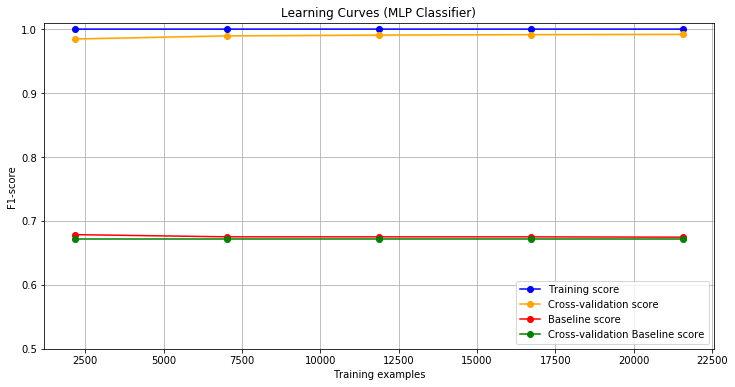

In [18]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
   
    plt.figure(figsize=(12, 6))
    plt.title('Learning Curves (%s)' % (title))
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, scoring='f1', train_sizes=train_sizes, verbose=0)
    
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="b")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="orange")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="b",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="orange",
             label="Cross-validation score")
    
    train_sizes, train_scores, test_scores = learning_curve(
    DummyClassifier(strategy='most_frequent'), X, y, cv=cv, n_jobs=n_jobs, scoring='f1', train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Baseline score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="green", 
             label="Cross-validation Baseline score")

    plt.legend(loc="lower right")
    return plt

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
plot_learning_curve(model, 'MLP Classifier', data['x_train'], data['y_train'], ylim=(0.5, 1.01), cv=cv, n_jobs=1)
plt.show()

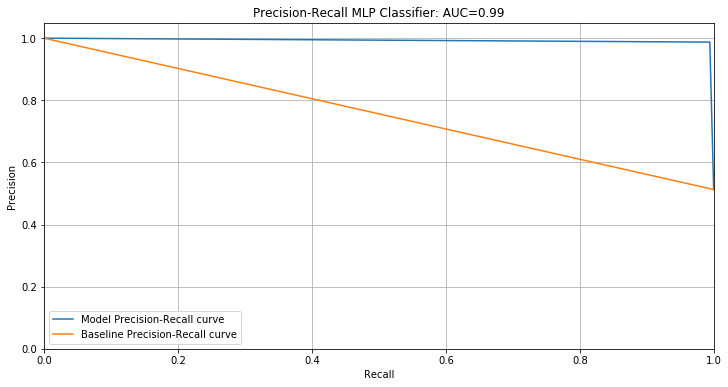

In [19]:
np.seterr(all='ignore')
    
pred = model.predict(data['x_test'])
precision, recall, thresholds = precision_recall_curve(data['y_test'], pred)
area = auc(recall, precision)

plt.figure(figsize=(12, 6))
plt.plot(recall, precision, label='Model Precision-Recall curve')

pred = DummyClassifier(strategy='most_frequent').fit(data['x_train'], data['y_train']).predict(data['x_test'])
precision, recall, thresholds = precision_recall_curve(data['y_test'], pred)

plt.plot(recall, precision, label='Baseline Precision-Recall curve')
plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall %s: AUC=%0.2f' % ('MLP Classifier',area))
plt.legend(loc="lower left")
plt.show()

## Checking the misclassified results

In [20]:
misclassifications = np.nonzero(model.predict(data['x_test']).reshape((-1,)) != data['y_test'])
misclassifications

(array([ 171,  244,  262,  296,  548,  688,  712,  844,  877,  892,  901,
        1024, 1123, 1271, 1302, 1308, 1358, 1393, 1613, 1618, 1619, 1896,
        1904, 2160, 2197, 2368, 3046, 3170, 3195, 3392, 3450, 3463, 3553,
        3875, 4055, 4134, 4277, 4306, 4425, 4511, 4515, 4634, 4731, 4771,
        4951, 5058, 5180, 5276, 5446, 5537, 5552, 5678, 5691, 5750, 5835,
        5925, 6158, 6186, 6202, 6295, 6315, 6452, 6462, 6597], dtype=int64),)

In [22]:
import random

def get_email_from_dataset(index_pos):
    print('True Email Class: ' + test.iloc[index_pos]['label'])
    print(test.iloc[index_pos]['text'][:2000] + '....')
    print()
    
for index in random.sample(list(misclassifications[0]),k=5):
    get_email_from_dataset(index)

True Email Class: Ham
Subject: how bout this one . ....

True Email Class: Spam
Subject: top brand new products directly from the manufactor ! ....

True Email Class: Spam
Subject: re : your document your document is attached .....

True Email Class: Ham
Subject: fw : computers happy holidays ! bonnie hitschel 210 - 283 - 2456 > subject : computers > > dear tech support , > > last year i upgraded from boyfriend 5 . 0 to husband 1 . 0 and noticed a > slowdown in the performance of flower and jewelry applications that had > operated flawlessly under boyfriend 5 . 0 . in addition , husband 1 . 0 > uninstalled many other valuable programs , such as romance 9 . 9 , and > installed > undesirable programs such as nfl 5 . 0 and nba 3 . 0 . > > conversation 8 . 0 no longer runs and housecleaning 2 . 6 simply crashes > the system . i ' ve tried running nagging 5 . 3 to fix these problems , but to > no avail . what can i do ? > > desperate > > > > - - - - - - - - - - - - - - - - - - - - - - - - -